In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Rescaling, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

tf.test.gpu_device_name()

Mounted at /content/drive


'/device:GPU:0'

(224, 224, 3)


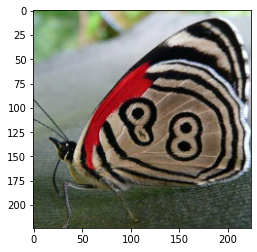

In [2]:
pil_im = Image.open('/content/drive/My Drive/UNIVERSIDAD/3 CURSO/FSI/p2/data/training/AN 88/1.jpg', 'r')
print(np.asarray(pil_im).shape)
plt.imshow(np.asarray(pil_im))
plt.show()

In [3]:
# DATA SOURCE -----------------------------------------

image_size = (224, 224)
batch_size = 15

train_dataset = keras.preprocessing.image_dataset_from_directory(
    directory="/content/drive/My Drive/UNIVERSIDAD/3 CURSO/FSI/p2/data/training",
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

valid_dataset = keras.preprocessing.image_dataset_from_directory(
    directory="/content/drive/My Drive/UNIVERSIDAD/3 CURSO/FSI/p2/data/validation",
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_dataset = train_dataset.prefetch(buffer_size=32)
valid_dataset = valid_dataset.prefetch(buffer_size=32)

Found 420 files belonging to 6 classes.
Found 120 files belonging to 6 classes.


In [4]:
# MODEL -----------------------------------------------

model = keras.Sequential()

model.add(Rescaling(
    scale=1./127.5,
    offset=-1,
    input_shape=(224,224,3)
))

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [5]:
# TRAINING --------------------------------------------

epochs = 100

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_dataset,
        epochs=epochs, 
        validation_data=valid_dataset,
        callbacks = [es]
)

Epoch 1/100
28/28 [==============================] - 201s 5s/step - loss: 1.7218 - accuracy: 0.2452 - val_loss: 1.4361 - val_accuracy: 0.3667
Epoch 2/100
28/28 [==============================] - 1s 44ms/step - loss: 1.3828 - accuracy: 0.4214 - val_loss: 1.1225 - val_accuracy: 0.6500
Epoch 3/100
28/28 [==============================] - 1s 44ms/step - loss: 1.0094 - accuracy: 0.6167 - val_loss: 0.9554 - val_accuracy: 0.6500
Epoch 4/100
28/28 [==============================] - 1s 42ms/step - loss: 0.7197 - accuracy: 0.7524 - val_loss: 0.6647 - val_accuracy: 0.7500
Epoch 5/100
28/28 [==============================] - 1s 42ms/step - loss: 0.5933 - accuracy: 0.8048 - val_loss: 0.5744 - val_accuracy: 0.7667
Epoch 6/100
28/28 [==============================] - 1s 43ms/step - loss: 0.4278 - accuracy: 0.8476 - val_loss: 0.5463 - val_accuracy: 0.7833
Epoch 7/100
28/28 [==============================] - 1s 42ms/step - loss: 0.3749 - accuracy: 0.8738 - val_loss: 0.5593 - val_accuracy: 0.8333
Epoch 

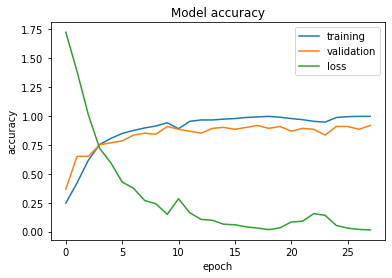

In [6]:
# EVALUATION ------------------------------------------

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        20
           1     0.8500    0.8947    0.8718        19
           2     0.8500    0.8500    0.8500        20
           3     0.9500    1.0000    0.9744        19
           4     0.9000    0.8571    0.8780        21
           5     0.9500    0.9048    0.9268        21

    accuracy                         0.9167       120
   macro avg     0.9167    0.9178    0.9168       120
weighted avg     0.9171    0.9167    0.9165       120



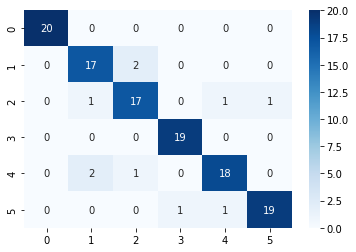

In [7]:
# RESULTS ---------------------------------------------

results = np.concatenate([(y, model.predict(x=x)) for x, y in valid_dataset], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [8]:
# TRANSFER-LEARNING -----------------------------------

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

model_transfer = VGG16(weights='imagenet', include_top=True)

553467096/553467096 [==============================] - 36s 0us/step


In [9]:
# TRANSFER-LEARNING MODEL -----------------------------

base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(6, activation='softmax')(x)

model_transfer = keras.Model(inputs, outputs)

58889256/58889256 [==============================] - 5s 0us/step


In [15]:
# TRANSFER-LEARNING TRAINING --------------------------

model_transfer.compile(loss=tf.keras.losses.categorical_crossentropy,
                      optimizer=tf.keras.optimizers.Adam(1e-3),
                      metrics=['accuracy'])

epochs = 5

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model_transfer.fit(
        train_dataset,
        epochs=epochs, 
        validation_data=valid_dataset,
        callbacks = [es]
)

Epoch 1/5
28/28 [==============================] - 5s 119ms/step - loss: 0.1626 - accuracy: 0.9619 - val_loss: 0.4548 - val_accuracy: 0.9250
Epoch 2/5
28/28 [==============================] - 3s 112ms/step - loss: 0.0768 - accuracy: 0.9833 - val_loss: 0.1008 - val_accuracy: 0.9667
Epoch 3/5
28/28 [==============================] - 3s 112ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1377 - val_accuracy: 0.9583
Epoch 4/5
28/28 [==============================] - 3s 113ms/step - loss: 2.2154e-04 - accuracy: 1.0000 - val_loss: 0.1404 - val_accuracy: 0.9583
Epoch 5/5
28/28 [==============================] - 3s 112ms/step - loss: 9.4094e-05 - accuracy: 1.0000 - val_loss: 0.1191 - val_accuracy: 0.9667


1/1 [==============================] - 0s 23ms/step
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        20
           1     1.0000    0.9524    0.9756        21
           2     0.8500    1.0000    0.9189        17
           3     1.0000    1.0000    1.0000        20
           4     1.0000    0.8696    0.9302        23
           5     0.9500    1.0000    0.9744        19

    accuracy                         0.9667       120
   macro avg     0.9667    0.9703    0.9665       120
weighted avg     0.9708    0.9667    0.9668       120



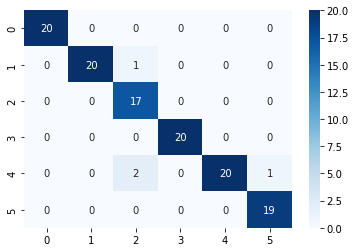

In [16]:
# TRANSFER-LEARNING RESULTS ---------------------------

results = np.concatenate([(y, model_transfer.predict(x=x)) for x, y in valid_dataset], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [17]:
img = keras.preprocessing.image.load_img(
    '/content/drive/My Drive/UNIVERSIDAD/3 CURSO/FSI/p2/data/test/BANDED PEACOCK/93.jpg', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
predictions_transfer = model_transfer.predict(img_array)

print(np.argmax(predictions[0]))
print(np.argmax(predictions_transfer[0]))

1/1 [==============================] - 0s 19ms/step
1
1


In [20]:
test_dataset = keras.preprocessing.image_dataset_from_directory(
    directory="/content/drive/My Drive/UNIVERSIDAD/3 CURSO/FSI/p2/data/test",
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 60 files belonging to 6 classes.


1/1 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        10
           1     0.8000    0.8889    0.8421         9
           2     0.9000    1.0000    0.9474         9
           3     1.0000    1.0000    1.0000        10
           4     0.9000    0.9000    0.9000        10
           5     1.0000    0.8333    0.9091        12

    accuracy                         0.9333        60
   macro avg     0.9333    0.9370    0.9331        60
weighted avg     0.9383    0.9333    0.9336        60



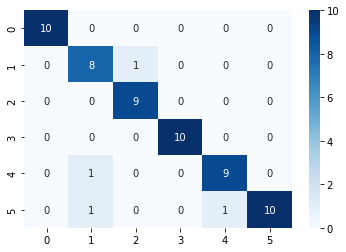

In [21]:
# MATRIZ DE CONFUSIÓN DE NUESTRO MODELO PARA EL PAQUETE DE TEST

results = np.concatenate([(y, model.predict(x=x)) for x, y in test_dataset], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

1/1 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        10
           1     0.9000    1.0000    0.9474         9
           2     1.0000    0.9091    0.9524        11
           3     1.0000    1.0000    1.0000        10
           4     1.0000    1.0000    1.0000        10
           5     1.0000    1.0000    1.0000        10

    accuracy                         0.9833        60
   macro avg     0.9833    0.9848    0.9833        60
weighted avg     0.9850    0.9833    0.9834        60



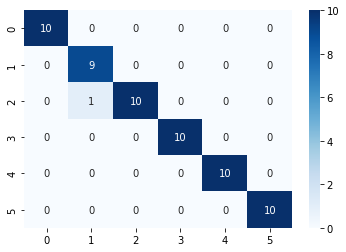

In [22]:
# MATRIZ DE CONFUSIÓN TRANSFER-LEARNING PARA EL PAQUETE DE TEST

results = np.concatenate([(y, model_transfer.predict(x=x)) for x, y in test_dataset], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))